In [5]:
%matplotlib inline
!pip install PyPortfolioOpt
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import random
from scipy.optimize import minimize
import seaborn as sns
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Random Stocks with Optimized Weights

In [3]:
def GenerateRandPortfolio(df, no_stocks, tot_stocks, seed = None):
    """This function takes in an integer and picks out that number of stocks to use as a random portfolio"""
    
    if seed is not None:
        random.seed(seed)

    # Initialising Stock Index Container
    stock_indexes = []
    
    # Picking 5 different random stocks
    for _ in range(no_stocks):
        # Making sure the stock isn't already picked
        stock_index = random.randint(1, tot_stocks)
        while stock_index in stock_indexes:
            stock_index = random.randint(1, tot_stocks)
        stock_indexes.append(stock_index)
    
    # Finding Labels for the portfolio
    stock_names = []
    for i in stock_indexes:
        stock_names.append(df.columns[i])
        
    # Returning the portfolio
    return df[stock_names]

In [18]:
pd.options.mode.chained_assignment = None

def GeneratePortfolios(num_stocks, method, prnt = False):

    """generates the porfolios over the whole dataset.
    
    method: either "min_volatility" or "max_sharpe". Defines the method for which the weights will be decided for each portfolio.
    num_stocks: An integer which represents the number of stocks each portfolio will contain.
    print: a boolean which indicates whether the results should be printed or not.
    """

    names = []
    exp_returns = []
    act_returns = []

    stocks = pd.read_csv('adjprice.csv')
    stop = False
    start_year = 1993
    end_year = 1999
    tracker = 0
    while stop == False:
        
        if end_year == 2019:
            stop = True
        
        stocks['Date'] = pd.to_datetime(stocks['Date'], format='%Y%m%d')
        
        StartDate = f"{start_year}/01/01"
        EndDate = f"{end_year}/01/01"

        #Stocks that last for the first 6 years

        stocks_short = stocks[(stocks["Date"] >= StartDate) & (stocks["Date"] <= EndDate)] #slicing based on chosen start and end dates.

        #dropping any stocks that have N/A values as this means they didnt exist during the chosen time period
        stocks_short.dropna(axis=1,inplace=True)

        #First 5 years of the dataframe above

        StartDate = f"{start_year}/01/01"
        EndDate = f"{end_year - 1}/01/31"
        stocks5 = stocks_short[(stocks_short["Date"] >= StartDate) & (stocks_short["Date"] <= EndDate)]

        # Read in price data
        df = stocks5.set_index('Date')

        #RANDOM SAMPLE
        portfolio = GenerateRandPortfolio(df, num_stocks, len(df.columns))

        df = portfolio

        # Calculate expected returns and sample covariance
        mu = expected_returns.mean_historical_return(df)
        S = risk_models.sample_cov(df)

        # Optimize for weights
        ef = EfficientFrontier(mu, S)

        if method == "max_sharpe":
            raw_weights = ef.max_sharpe()
        elif method == "min_volatility":
            raw_weights = ef.min_volatility()
        else:
            raise KeyError("method choosen is not valid")
        
        cleaned_weights = ef.clean_weights()
        ef.set_weights(cleaned_weights)
        weights5 = ef.weights
        values = ef.portfolio_performance()
        port_exp = values[0]


        #The following year

        StartDate = f"{end_year - 1}/01/01"
        EndDate = f"{end_year}/01/01"
        
        stocks_next = stocks_short[(stocks_short["Date"] >= StartDate) & (stocks_short["Date"] <= EndDate)]

        portfolio_next = pd.DataFrame(stocks_next["Date"],columns=['Date'])
        for col in stocks_next.columns: # go through all the columns in our original data frame
            if col in portfolio.columns: # check if this column is in the names for our random sample
                portfolio_next = pd.concat([portfolio_next,stocks_next[col]],axis=1) # if so, add the stock prices to the new dataframe


        df = portfolio_next.set_index('Date')

        # Calculate expected returns and sample covariance
        mu = expected_returns.mean_historical_return(df)

        if prnt == True:
            print(f"Portfolio Year {end_year-1} - {end_year}:")
            print(f"Expected Return from Portfolio: {port_exp}")
            print(f"Actual Return for following Year: {mu.dot(weights5)}")
            print("")

        portfolio1 = portfolio_next.set_index('Date')
        portfolio1['Optimized Portfolio'] = 0

        for ticker, weight in cleaned_weights.items():
            portfolio1['Optimized Portfolio'] += portfolio1[ticker]*weight

        if tracker == 0:
            cum_port = portfolio1
            tracker += 1
        else:
            cum_port = pd.concat([cum_port, portfolio1])

        names.append(f"{end_year-1} - {end_year}:")
        exp_returns.append(port_exp)
        act_returns.append(mu.dot(weights5))
        
        start_year += 1
        end_year += 1

    return [names, exp_returns, act_returns], cum_port

In [19]:
values, df = GeneratePortfolios(method="max_sharpe", num_stocks= 10)

In [20]:
def plot_cum_returns(data, title):    
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig

In [21]:
plot_cum_returns(df["Optimized Portfolio"], "Cumulative Returns of Optimized Portfolio Starting with $100")

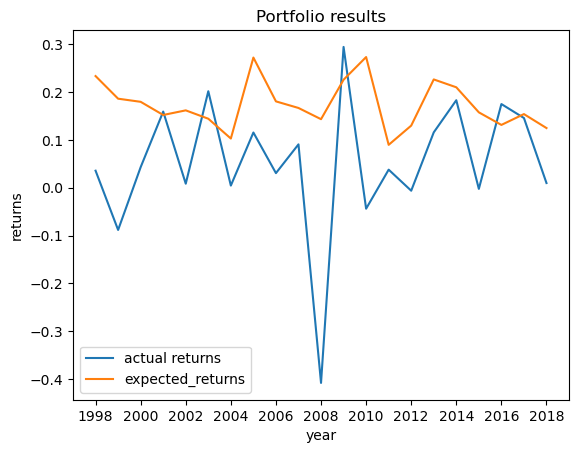

total returns: 1.1


In [22]:
x_axis = np.arange(start = 1998, stop = 2019)
y_axis1 = values[2]
y_axis2 = values[1]

plt.plot(x_axis, y_axis1, label = "actual returns")
plt.plot(x_axis, y_axis2, label = "expected_returns")
plt.title('Portfolio results')
plt.xlabel('year')
plt.ylabel('returns')
plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 2))
plt.legend()
plt.show()

print(f"total returns: {round(sum(values[2]),2)}")

In [23]:
values2, df2 = GeneratePortfolios(method="min_volatility", num_stocks= 10)

In [24]:
plot_cum_returns(df2["Optimized Portfolio"], "Cumulative Returns of Optimized Portfolio Starting with $100")

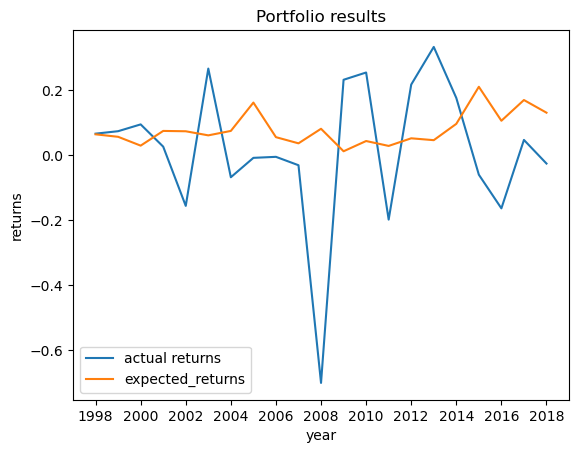

total returns: 0.37


In [25]:
x_axis = np.arange(start = 1998, stop = 2019)
y_axis1 = values2[2]
y_axis2 = values2[1]

plt.plot(x_axis, y_axis1, label = "actual returns")
plt.plot(x_axis, y_axis2, label = "expected_returns")
plt.title('Portfolio results')
plt.xlabel('year')
plt.ylabel('returns')
plt.xticks(np.arange(min(x_axis), max(x_axis)+1, 2))
plt.legend()
plt.show()

print(f"total returns: {round(sum(values2[2]),2)}")